<div hidden>
    $\newcommand{\q}{\left}$
    $\newcommand{\w}{\right}$
    $\newcommand{\m}{\middle}$
    $\newcommand{\e}{\boldsymbol}$
    $\newcommand{\cb}{\mspace{3mu}\m\vert\mspace{3mu}}$
</div>

<center>
    Sveučilište u Zagrebu<br>
    Fakultet elektrotehnike i računarstva<br>
    <a href="http://www.fer.unizg.hr/predmet/dubuce">Duboko učenje 2</a>
</center>

<h1>
    Laboratorijska vježba 1: <br> Uvod u generativne modele
</h1>

In [19]:
# automatsko 're-importanje' modula kada se nešto izmijeni
%load_ext autoreload
%autoreload 2

# podešavanje fonta i margina radi bolje čitkosti
# odabrati File -> Trust notebook
from IPython.display import display, HTML

display(HTML('<link rel="stylesheet" href="https://fonts.googleapis.com/css?family=Source Serif Pro">'))

with open("style.css", "r") as file:
    display(HTML('<style>' + file.read() + '</style>'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import math

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams["figure.figsize"] = (6, 4.5)
sns.set_context("notebook")

from graphics import plot_context

In [22]:
import re

hidden_div_rgx = re.compile(r"(?<=<div hidden>\\n\",).*"
                            r"(?=\s*\"\s*</div>\\n\")", re.DOTALL)

cmd_rgx = re.compile(r"\s*\"\s*\$\\\\newcommand"
                     r"\{(?P<key>[^}]*)}"
                     r"\{(?P<value>\S*)(?=}\$\\n\",)}\$\\n\",")

mspace_rgx = re.compile(r"\\\\mspace\{-?[0-9]+mu}")


def replace(ipynb: str) -> str:
    print(hidden_div_rgx.search(ipynb).span())
    replacements = {}
    for it in cmd_rgx.finditer(ipynb, *hidden_div_rgx.search(ipynb).span()):
        replacements[it.groupdict()["key"]] = it.groupdict()["value"]
    for i in range(2):  # for when "value" contains previous "key"
        for key, value in replacements.items():
            value = mspace_rgx.sub(" ", value)
            ipynb = re.sub(key.replace("\\", "\\\\") + "(?=[^a-zA-Z0-9])",
                           value.replace("\\", "\\\\"), ipynb)
    return hidden_div_rgx.sub("", ipynb)


if __name__ == "__main__":
    with open("lab_1.ipynb", 'r', encoding="utf8") as istream:
        data = istream.read()
    with open("lab_1_replaced_tex_commands.ipynb", 'w', encoding="utf8") as ostream:
        ostream.write(replace(data))

(122, 371)


## 1. Modeli mješavine

<b>Modeli mješavine</b> (engl. <i>mixture models</i>) su vjerojatnosni modeli koji distribuciju podataka $\e x$ definiraju koristeći $K$-vrijednosnu kategorijsku slučajnu varijablu $\e z$ tako da, ovisno o realizaciji varijable $\e z$ kao $z_k$, podatak $\e x$ dolazi iz jedne od mogućih $K$ različitih distribucija.
Funkcija gustoće vjerojatnosti koju opisuju je
\begin{equation}
    p_{\e \theta}\q(\e x\w) = \sum_{k=1}^K p_{\e \theta}\q(\e x, z_k\w) = \sum_{k=1}^K p_{\e \theta}\q(\e x \cb z_k\w) \cdot p_{\e \theta}\q(z_k\w),
\end{equation}
Pripadna funkcija razdiobe varijable $\e z$ definirana je vektorom razdiobe $\e \pi$:
\begin{equation}
    p_{\e \theta}\q(z_k\w) = \pi_k,
\end{equation}
pri čemu vrijedi $\pi_k \ge 0$, za $k = 1, 2, \ldots, K$, i $\sum_{k=1}^K \pi_k = 1$.
Uvjetna gustoća vjerojatnosti $p_{\e \theta}\q(\e x \cb z_k\w)$ predstavlja $k$-tu komponentu mješavine, a $\pi_k$ ujedno daje težinu $k$-te komponente mješavine.
Oznakom $\e \theta$ označava se skup svih parametara modela.

Uvjetna gustoća vjerojatnosti $p_{\e \theta}\q(\e x \cb z_k\w)$ zadaje se tako da za različite vrijednosti $z_k$ ima isti funkcijski oblik, ali različite vrijednosti parametara.
Izaberemo li kao $p\q(\e x \cb z_k\w)$ <a href="https://www.wikiwand.com/en/Normal_distribution">univarijatnu normalnu razdiobu</a>, dobivamo model koji gustoću vjerojatnosti opisuje kao
\begin{equation}
p_{\e \theta}\q(x\w) = \sum_{k=1}^K \pi_k \cdot \mathcal N \left(x; \mu\q(z_k\w), \sigma^2\q(z_k\w)\right) = \frac{1}{\sqrt{2 \pi \sigma^2\q(z_k\w)}} \cdot \exp\q(-\frac{1}{2} \cdot \frac{\q(x - \mu\q(z_k\w)\w)^2}{\sigma^2\q(z_k\w)}\w),
\end{equation}
gdje je s $\mathcal N \left(x; \mu, \sigma^2\right)$ označena gustoća vjerojatnosti normalne slučajne varijable s parametrima srednje vrijednosti $\mu$ i varijance $\sigma^2$.
Takav model zovemo još i <b>Gaussovom mješavinom</b>.
Kako je ovdje $\e z$ kategorijska slučajna varijabla (koja može poprimiti konačno mnogo vrijednosti), dovoljno je definirati $\mu\q(\e z\w)$ i $\sigma^2\q(\e z\w)$ preko $K$ različitih parametara $\mu_k$ i $\sigma^2_k$, za $k = 1, 2, \ldots, K$:
\begin{align}
    \mu\q(z_k\w) &= \mu_k, \\
    \sigma^2\q(z_k\w) &= \sigma^2_k.
\end{align}
Skup svih parametara je u tom slučaju $\e \theta = \q\{ \e \pi, \e \mu, \e {\sigma^2} \w\}$, gdje su $\e \pi = \q[\pi_1, \pi_2, \ldots, \pi_K \w]$, $\e \mu = \q[\mu_1, \mu_2, \ldots, \mu_K \w]$, i $\e {\sigma^2} = \q[\sigma^2_1, \sigma^2_2, \ldots, \sigma^2_K \w]$.

---
<b>a)</b>
Proučite priloženu klasu `GMModel` iz modula `models` koja implementira distribuciju Gaussove mješavine.
Pomoću te klase generirajte jednu distribuciju s proizvoljnim vrijednostima parametara:
 - `pi`: vektor težina komponenata $\e \pi$, dimenzija $K$,
 - `mu`: vektor srednjih vrijednosti $\e \mu$, dimenzija $K$, i
 - `sigma2`: vektor varijanci $\e \sigma^2$, dimenzija $K$;

ili koristite metodu `GMDist.random` za generiranje neke slučajne mješavine.
Preporučen broj komponenata mješavine je <b>između 3 i 5</b>.

Generirajte slučajni uzorak iz dobivene mješavine veličine $1000000$.
Nacrtajte na dva odvojena grafa:
 1. histogram generiranog uzorka (funkcija `plt.hist`, parametar bins postavite dovoljno velik i uključite `density=True` da njegova površina bude 1), i
 2. graf gustoće vjerojatnosti mješavine $p\q(\e x\w)$ i njezinih komponenata $\pi_k \cdot p\q(\e x; \mu_k, \sigma^2_k\w)$.

<p></p>

Uvjerite se da se dobiveni grafovi podudaraju (vidite [priloženu sliku](slika_1.png) za referencu).
Isprobajte par različitih vrijednosti parametara dok ne dobijete "zanimljivu" mješavinu koju ćete koristiti u podzadatcima <b>b)</b> i <b>c)</b>.

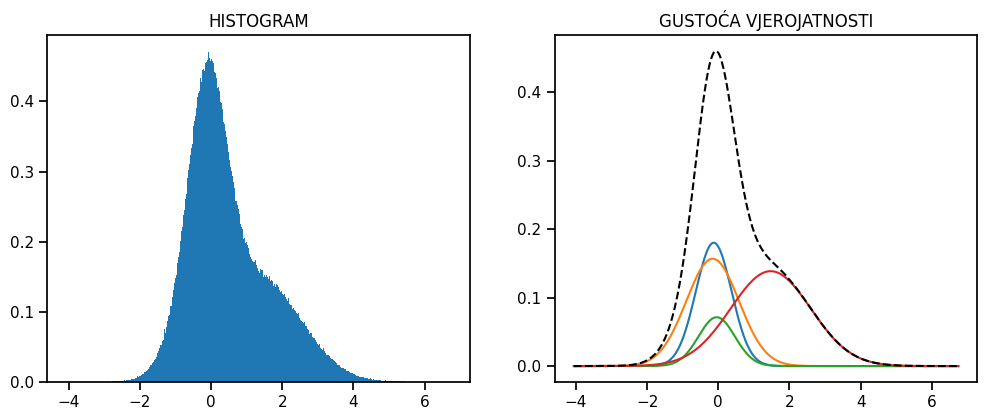

In [30]:
from dists import GMDist
from models import GMModel
from dists import GMDist
K = 4
L = 1000000

dist = GMDist.random(K)
data = dist.sample(L)
data.sort()

with plot_context(figsize=(12, 4.5), show=True):
    with plot_context(subplot=(1, 2, 1), title="HISTOGRAM"):
        plt.hist(data, bins=500, density=True)  # histogram

    with plot_context(subplot=(1, 2, 2), title="GUSTOĆA VJEROJATNOSTI"):
        for i in range(K):
           plt.plot(data, dist.pi[i] * dist.p_xz(data, i))  # komponente, pomnožene pripadajućim težinama
    
        plt.plot(data, dist.p_x(data), 'k--')  # cijela mješavina

U vjerojatnosnom modeliranju pretpostavlja se da skup podataka $\mathcal D = \q\{ \e x^{(1)}, \e x^{(2)}, \ldots, \e x^{(N)} \w\}$ sadrži realizacije neke slučajne varijable $\e x$.
Prema kriteriju najveće izglednosti (engl. <i>maximum likelihood</i>), pri učenju modela biramo parametre $\e \theta$ koji daju najveću izglednost uz zadani skup podataka.
Uvedemo li dodatnu pretpostavku da svi podatci dolaze kao realizacije iste slučajne varijable (odnosno kolekcije <a href="https://www.wikiwand.com/en/Iid">međusobno nezavisnih i jednako distribuiranih slučajnih varijabli</a>), funkcija izglednosti poprima oblik
\begin{equation}
    \mathcal L\q(\e \theta \cb \mathcal D\w) = p_{\e \theta}\q(\e x^{(1)}, \e x^{(2)}, \ldots, \e x^{(N)}\w) = \prod_{i=1}^N p_{\e \theta}\q(\e x^{(i)}\w).
\end{equation}

Funkcija izglednosti u svom izvornom obliku nezgrapna je za deriviranje, pa se stoga češće koristi njezin logaritam (oboje poprima maksimum za istu vrijednost parametara).
K tome je u strojnom učenju uobičajeno <b>minimizirati</b> nekakvu empirijsku mjeru pogreške koja je suma gubitaka po svim primjerima, pa je zgodno definirati empirijsku pogrešku kao <b>negativan logaritam izglednosti</b>, odnosno
\begin{equation}
    E\q(\e \theta \cb \mathcal D\w) = -\sum_{i=1}^N \log p_{\e \theta}\q(\e x^{(i)}\w),
\end{equation}
iz čega slijedi da je funkcija gubitka za jedan primjer $L_{\e \theta}\q(\e x^{(i)}\w) = -\log p_{\e \theta}\q(\e x^{(i)}\w) $.

---
<b>b)</b>
Dovršite implementaciju modela Gaussove mješavine `GMDist` iz modula `tf_utils` &mdash; dovršite sljedeće funkcije:
 - `loss(data)` &mdash; računa gubitak (ili vektor gubitaka) jednog primjera (ili vektora primjera),
 - `p_xz(x, k)` &mdash; računa gustoću vjerojatnosti primjera za $k$-tu komponentu, i
 - `p_x(x)` &mdash; računa gustoću vjerojatnosti primjera;
 
ili napišite vlastitu implementaciju koristeći biblioteku za duboko učenje po želji (<b>tensorflow</b>, <b>pytorch</b>).
Vašu implementaciju ćete trebati koristiti u narednim podzadatcima, stoga razmislite o tome da kōd izolirate u  klasu ili ga rasporedite kroz nekoliko funkcija.

Parametri modela analogni su parametrima distribucije $\e \pi$, $\e \mu$ i $\e \sigma^2$, no ipak, prilikom pretraživanja prostora parametara gradijentnim spustom željeli bismo izbjeći ograničenja koja ti parametri moraju zadovoljavati, konkretno:
\begin{align}
    \pi_k &\ge 0, \quad \text{za} \, k = 1, 2, \ldots, K, \\
    \sum_{k=1}^K \pi_k &= 1, \\
    \sigma^2_k &> 0, \quad \text{za} \, k = 1, 2, \ldots, K.
\end{align}
Zato se umjesto vektora težina komponenata $\e \pi$ uči vektor logaritama težina komponenata, $\operatorname{\mathbf{log}} \e \pi$ (varijabla `logpi` u priloženom kodu), a umjesto vektora varijanci $\e {\sigma^2}$ također vektor logaritama varijanci $\operatorname{\mathbf{log}} \e \sigma^2$ (varijabla `logvar` u priloženom kodu).
Razlog je taj što logaritmi tih parametara smiju poprimiti bilo koju realnu vrijednost i pritom nisu međusobno vezani.
Težine komponenata dobivaju se natrag primjenom funkcije $\operatorname{\mathbf{softmax}}$: $\e \pi = \operatorname{\mathbf{softmax}}\q(\operatorname{\mathbf{log}}\e \pi\w)$, gdje je
\begin{equation}
    \operatorname{softmax}_k\q(\e x\w) = \frac{\exp x_k}{\sum_{j=1}^K \exp x_j},
\end{equation}
a varijance primjenom funkcije $\operatorname{\mathbf{exp}}$, $\e{\sigma^2} = \operatorname{\mathbf{exp}}\q(\operatorname{\mathbf{log}}\e {\sigma^2}\w)$.

Naposljetku, radi sprječavanja gubitka preciznosti, kao i radi bržeg treniranja, preporučeno je od početka raditi s negativnim logaritmima gustoće vjerojatnosti (umjesto samim gustoćama vjerojatnosti).
U tom slučaju prirodno je definirati gubitke ostalih varijabli, $L_{\e \theta}\q(x^{(i)} \cb z_k\w)$ i $L_{\e \theta}\q(z_k\w)$, kao
\begin{align}
    L_{\e \theta}\q(x^{(i)} \cb z_k\w) &= -\log \mathcal N \q(x; \mu_k, \sigma^2_k\w) = \frac{1}{2} \cdot \q(\log 2\pi + \log \sigma^2 + \frac{\q(x - \mu\w)^2}{\sigma^2}\w), \quad \text{i} \\
    L_{\e \theta}\q(z_k\w) &= -\log \operatorname{softmax}_k \q(\operatorname{\mathbf{log}} \e \pi\w) = \log \sum_{j=1}^K \exp \q(\operatorname{\mathbf{log}} \pi\w)_j - \q(\log \pi\w)_k
\end{align}
pa gubitak primjera $x^{(i)}$ u terminima $L_{\e \theta}\q(x^{(i)} \cb z_k\w)$ i $L_{\e \theta}\q(z_k\w)$ iznosi
\begin{align}
    L_{\e \theta}\q(x^{(i)}\w) &= - \log \sum_{k=1}^K \pi_k \cdot \mathcal N \q(x^{(i)}; \mu_k, \sigma^2_k\w) \\ 
    &= -\log \sum_{k=1}^K \exp \q(-\q( L_{\e \theta}\q(x^{(i)} \cb z_k\w) + L_{\e \theta}\q(z_k\w) \w)\w).
\end{align}
Operacija $\operatorname{LSE}\q(\e x\w) = \log \sum_{k=1}^K \exp x_k$ naziva se <a href="https://www.wikiwand.com/en/LogSumExp">logaritam sume eksponenata</a>. Biblioteke za duboko učenje nude implementaciju te operacije (`tf.reduce_logsumexp`, `torch.logsumexp`) kod koje dolazi do minimalnog gubitka preciznosti.
Pokušajte iskoristiti navedenu operaciju prilikom računanja pogreške; ako baš ne ide, izračunajte gustoću vjerojatnosti pa uzmite njezin negativan logaritam.

U nastavku je dan kōd koji možete iskoristiti za treniranje modela.

In [ ]:
from models import GMModel

model = GMModel(K)
optimizer = tf.optimizers.Adam(1e-2)

L = 1000
data = dist.sample(L).reshape([-1, 1])
batch_size = 1000
num_epoch = 5000

for epoch in range(num_epoch):
    for i in range(math.ceil(L / batch_size)):
        chunk = data[i * batch_size:(i + 1) * batch_size]
        
        with tf.GradientTape() as tape:
            loss = tf.reduce_mean(model.loss(chunk), axis=0)

        grad = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grad, model.variables))
    
    display(HTML(f"EPOCH {epoch} / {num_epoch}"), clear=True)

<b>c)</b> Prikažite na istom grafu:
1. zadanu funkciju gustoće,
2. naučenu funkciju gustoće, i
3. histogram izvučenog uzorka.

Vidite <a href="slika_2.png">priloženu sliku</a> za referencu.

<p></p>
Slaže li se naučena gustoća sa zadanom?
Reprezentira li uzorak podataka zadanu distribuciju dovoljno dobro?

In [ ]:
...

with plot_context(show=True, legend=["ZADANO", "NAUČENO", "UZORAK"]):
    plt.plot  # zadana gustoća
    plt.plot  # naučena gustoća
    plt.hist  # histogram uzorka za učenje

<b>d)</b> Prikažite na dva odvojena grafa:
 1. zadanu gustoću vjerojatnosti mješavine i njenih pripadajućih komponenata, i
 2. naučenu gustoću vjerojatnosti mješavine i njenih pripadajućih komponenata.

Odgovaraju li komponente naučene mješavini komponentama iz zadane mješavine?

In [ ]:
...

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title="ZADANO"):
        for k in range(K):
            plt.plot  # komponente, pomnožene pripadajućim težinama
            
        plt.plot  # cijela mješavina
            
    with plot_context(subplot=(1, 2, 2), title="NAUČENO"):
        for k in range(model.K):
            plt.plot  # komponente, pomnožene pripadajućim težinama
            
        plt.plot  # cijela mješavina

<b>e)</b>
Naučeni model mješavine može se koristiti i za <b>grupiranje podataka</b> (<i>clustering</i>) u $K$ grupa.
Uvjetna vjerojatnost $p_{\e \theta}\q(z_k \cb \e x\w)$ za $k = 1, 2, \ldots, K$, predstavlja vjerojatnost da primjer $\e x$ dolazi iz $k$-te komponente mješavine i računa se kao
\begin{equation}
    p_{\e \theta}\q(z_k \cb \e x\w) = \frac{p_{\e \theta}\q(\e x, z_k\w)}{p_{\e \theta}\q(\e x\w)} = \frac{\pi_k \cdot p_{\e \theta}\q(\e x \cb z_k\w)}{\sum_{i=1}^K \pi_i \cdot p_{\e \theta}\q(\e x \cb z_i\w)}.
\end{equation}
Kriterij maksimalne izglednosti daje podjelu skupa podataka $\mathbb X$ na $K$ disjunktnih grupa na sljedeći način:
\begin{equation}
    \mathcal G_k = \q\{ \e x \in \mathbb X \cb \operatorname{arg\,max}_i p_{\e \theta}\q(z_i \cb \e x\w) = k \w\}
\end{equation}

Izvucite uzorak od 1000000 primjera iz prethodno zadane distribucije.
Nacrtajte na $K$ odvojenih grafova histograme pojedinih grupa.
Vidite <a href="slika_3.png">priloženu sliku</a> za referencu.

In [ ]:
L = 1000000
data = dist.sample(L)

_, bins = np.histogram(data, bins=1001)  # ako želimo imati iste 'koševe' u svim grafovima: plt.hist(..., bins=bins)

with plot_context(show=True, figsize=(6, 4.5 * model.K / 2), suptitle="GRUPE"):
    for k in range(K):
        with plot_context(subplot=(model.K, 1, k + 1), legend=[f"k={k}"]):
            plt.hist  # histogram grupe

<b>f)</b>
Implementirajte mješavinu (kontinuiranih) <a href="https://www.wikiwand.com/en/Continuous_uniform_distribution">uniformnih distribucija</a> po uzoru na priloženu implementaciju Gaussove mješavine.
Možete dopuniti zadanu klasu `UMDist` ili napisati vlastiti kod po želji.

Ponovno nacrtajte histogram i graf gustoće vjerojatnosti kao u podzadatku <b>a)</b>.
Koristite <b>2 do 3</b> komponente.
Generirajte neku "zanimljivu" mješavinu koju ćete koristiti u sljedećem podzadatku.

In [ ]:
from dists import UMDist

K = ...
L = 1000000

dist = ...
data = dist.sample(L)

with plot_context(figsize=(12, 4.5), show=True):
    with plot_context(subplot=(1, 2, 1), title="HISTOGRAM"):
        plt.hist  # histogram

    with plot_context(subplot=(1, 2, 2), title="GUSTOĆA VJEROJATNOSTI"):
        for i in range(K):
            plt.plot  # komponente, pomnožene pripadajućim težinama
    
        plt.plot  # cijela mješavina

<b>g)</b>
Zatim iskoristite model Gaussove mješavine da biste naučili prethodno generiranu mješavinu uniformnih distribucija.
Varirajte broj komponenata mješavine <b>modela</b> (ne distribucije) <b>između 3 i 10</b>, te veličinu uzorka za učenje i broj epoha.
U nastavku je dan kod za treniranje.

In [ ]:
from models import GMModel

model = GMModel(10)
optimizer = tf.optimizers.Adam(1e-2)

L = 10000
data = dist.sample(L).reshape([-1, 1])
batch_size = 1000
num_epoch = 5000

for epoch in range(num_epoch):
    for i in range(math.ceil(L / batch_size)):
        chunk = data[i * batch_size:(i + 1) * batch_size]
        
        with tf.GradientTape() as tape:
            loss = tf.reduce_mean(model.loss(chunk), axis=0)

        grad = tape.gradient(loss, model.variables)
        optimizer.apply_gradients(zip(grad, model.variables))
    
    display(HTML(f"EPOCH {epoch} / {num_epoch}"), clear=True)

<b>i)</b> Ponovite vizualizacije iz <b>c)</b> i <b>d)</b> podzadataka.
Slaže li se naučena gustoća sa zadanom?
Reprezentira li uzorak podataka zadanu distribuciju dovoljno dobro?
Može li model Gaussove mješavine dobro aproksimirati i druge složene distribucije?

In [ ]:
...

with plot_context(show=True, legend=["ZADANO", "NAUČENO", "UZORAK"]):
    plt.plot  # zadana gustoća
    plt.plot  # naučena gustoća
    plt.hist  # histogram uzorka za učenje
    
print(np.sum(model_pdf) * delta)

In [ ]:
...

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title="ZADANO"):
        for k in range(K):
            plt.plot  # komponente, pomnožene pripadajućim težinama
            
        plt.plot  # cijela mješavina
            
    with plot_context(subplot=(1, 2, 2), title="NAUČENO"):
        for k in range(model.K):
            plt.plot  # komponente, pomnožene pripadajućim težinama
            
        plt.plot  # cijela mješavina

## 2. Probabilistička regresija

U klasičnoj regresiji, raspolažemo skupom podataka i njihovih pripadajućih oznaka $\mathcal D = \q\{ \q(\e x^{(i)}, y^{(i)}\w) \w\}$.
Cilj je naučiti funkcijsku ovisnost između podatka $\e x$ i njegove oznake $y$.
Tu funkciju opisujemo neuronskom mrežom $f_{\e \theta}$,
\begin{equation}
    y^{(i)} = f_{\e \theta}\q(\e x^{(i)}\w) + \epsilon^{(i)}
\end{equation}
gdje $\e \theta$ označava skup svih parametara te mreže, a $\epsilon^{(i)}$ slučajni šum.
Šum može biti <a href="https://www.wikiwand.com/en/Measurement_error">mjerni šum</a>, ali on također može dolaziti i od neosmotrenih (latentnih) varijabli koje utječu na oznaku $y^{(i)}$, ali njihove vrijednosti nam nisu poznate, pa je stoga model nepotpun.
Sam šum nije dio modela, već se najbolja točkasta procjena oznake $i$-tog podatka $\hat{y}^{(i)}$ dobiva kao
\begin{equation}
    \hat{y}^{(i)} = f_{\e \theta}\q(\e x^{(i)}\w).
\end{equation}
Definiramo proizvoljnu funkiju gubitka $L_{\e \theta}\q(\hat{y}, y\w)$, najčešće kvadratni $\q(y - \hat{y}\w)^2$ ili apsolutni gubitak $\q\lvert y - \hat{y} \w\rvert$.
Sada se optimalna funkcija $f_{\e \theta}$ može pronaći minimiziranjem empirijskog gubitka
\begin{equation}
    E\q(\e \theta \cb \mathcal D\w) = \sum_{i = 1}^N L_{\e \theta}\q(\hat{y}^{(i)}, y^{(i)}\w).
\end{equation}

U probabilističkoj regresiji, oznaku $i$-tog podatka $y^{(i)}$ tretiramo kao realizaciju slučajne varijable $\q. y \cb \e x^{(i)} \w.$.
Zadajemo odgovarajuću parametriziranu distribuciju $p_{\e \theta}\q(y \cb \e x\w)$ kojom ćemo opisati te realizacije.
U većini slučajeva to će biti normalna distribucija $\mathcal N\q(\mu\q(\e x\w), \sigma^2\q(\e x\w)\w)$, ali možemo zadati i neku drugu.
Nadalje, želimo odabrati parametre $\e \theta$ za koje je izglednost da generiraju dostupne oznake najveća.
Uz iste pretpostavke kao u prethodnom zadatku, definiramo izglednost
\begin{equation}
    \mathcal L\q(\e \theta \cb \mathcal D\w) = \prod_{i = 1}^N p_{\e \theta}\q(y^{(i)} \cb \e x^{(i)}\w),
\end{equation}
odnosno empirijsku pogrešku
\begin{equation}
    E\q(\e \theta \cb \mathcal D\w) = -\sum_{i = 1}^N \log p_{\e \theta}\q(y^{(i)} \cb \e x^{(i)}\w).
\end{equation}

U ostatku ovog zadatka modelirat ćemo podatke u skladu sa sljedećim distribucijama:
\begin{align}
    x &\sim \mathcal N\q(0, 1\w),  \\
    \left. y \, \middle \vert \, x \right. &\sim \mathcal N\left(\mu \left(x\right), \sigma^2\left(x\right) \right).
\end{align}
Funkcije $\mu\q(x\w)$ i $\sigma^2\q(x\w)$ opisat ćemo neuronskom mrežom.
Parametri $\e \theta$ parametri su te mreže.
Izlaz modela više nije točkasta procjena $\hat{y}$, već slučajna varijabla koja nam može nešto reći i o nesigurnosti procjene, odnosno šumu kojeg klasična regresija zanemaruje.

---
<b>a)</b>
Proizvoljno definirajte funkcije `mean_y(x)` i `sigma2_y(x)` koje opisuju ovisnost parametara $\mu$ i $\sigma^2$ uvjetne slučajne varijable $\q.y \cb x\w.$ u ovisnosti o realizaciji slučajne varijable $x$.
Napravite funkciju `gen_data(L)` koja generira $L$ uzoraka slučajne varijable $x$ i njima pripadnih oznaka $y$.

Zatim generirajte uzorak veličine $L = 1000$ i odvojeno prikažite:
 1. graf intervala pouzdanosti širine 1-$\sigma$ uvjetne slučajne varijable $\q. y \cb x \w.$ (to je raspon vrijednosti između $\mu - \sigma$ i $\mu + \sigma$),
 2. graf raspršenja generiranog uzorka.

Vidite <a href="slika_4.png">priloženu sliku</a> za referencu.
Varirajte funkcije `mean_y` i `sigma2_y` tako da dobijete neku "zanimljivu" distribuciju.

In [ ]:
mean_y = lambda x: ...
sigma2_y = lambda x: ...

L = 1000

def gen_data(L):
    X = ...
    Y = ...
    
    return X, Y

X, Y = gen_data(L)

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title="1-$\sigma$ INTERVAL POUZDANOSTI", legend=["$\mu$", "$\mu \pm \sigma$"]):
        plt.plot  # srednja vrijednost
        plt.fill_between  # interval povjerenja

    with plot_context(subplot=(1, 2, 2), title="UZORAK"):
        plt.scatter  # uzorak

<b>b)</b>
Koristite neuronsku mrežu za učenje parametara uvjetne slučajne varijable $\q. y \cb x \w.$.
Varirajte broj slojeva mreže <b>između 2 i 5</b> (ne brojeći ulazni sloj), te isprobajte različite kombinacije broja čvorova u skrivenim slojevima.
Po želji možete isprobati i različite aktivacijske funkcije u skrivenim slojevima.
Izlazni sloj mora imati $2$ čvora, te na njega ne smije biti primijenjena aktivacija.
Dovršite kod za treniranje, pa istrenirajte model nad generiranim uzorkom.

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(100, activation="relu"),
                             tf.keras.layers.Dense(100, activation="relu"),
                             tf.keras.layers.Dense(2, activation=None)])

optimizer = tf.optimizers.Adam(1e-3)

for _ in range(1000):
    X, Y = gen_data(100)
    
    with tf.GradientTape() as tape:
        mean, logvar = tf.split(model(X.reshape([-1, 1])), num_or_size_splits=[1, 1], axis=1)
        loss = ...

    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

<b>c)</b> Na dva odvojena grafa prikažite interval pouzdanosti širine 1-$\sigma$ uvjetne slučajne varijable $\q. y \cb x \w.$
 1. zadane distribucije, i
 2. naučenog modela.

Podudaraju li se grafovi?
Može li naučeni model generirati nove primjere slične onima iz skupa za učenje?

In [ ]:
...

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title="ZADANO"):
        plt.plot  # srednja vrijednost
        plt.fill_between  # interval pouzdanosti
        
    with plot_context(subplot=(1, 2, 2), title="NAUČENO"):
        plt.plot  # srednja vrijednost
        plt.fill_between  # interval pouzdanosti

<b>d)</b>
Za usporedbu istrenirajte i klasičan model regresije uz kvadratni ili apsolutni gubitak, pa na dva odvojena grafa prikažite:
 1. interval pouzdanosti širine 1-$\sigma$ uvjetne slučajne varijable $\q. y \cb x \w.$ zadane distribucije, i
 2. točkastu procjenu oznake $\hat{y}$ koju daje model i graf raspršenja uzorka veličine $L = 100$.

Pogađa li procjena modela približno točke u grafu raspršenja?

In [ ]:
model = tf.keras.Sequential([tf.keras.layers.Dense(100, activation="relu"),
                             tf.keras.layers.Dense(100, activation="relu"),
                             tf.keras.layers.Dense(1, activation=None)])

optimizer = tf.optimizers.Adam(1e-3)

for _ in range(1000):
    X, Y = gen_data(100)
    
    with tf.GradientTape() as tape:
        y_hat = model(X.reshape([-1, 1]))
        loss = ...
        
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))

In [ ]:
...

X, Y = gen_data(100)

with plot_context(show=True, figsize=(12, 4.5)):
    with plot_context(subplot=(1, 2, 1), title="ZADANO"):
        plt.plot  # srednja vrijednost
        plt.fill_between  # interval pouzdanosti
        
    with plot_context(subplot=(1, 2, 2), title="NAUČENO"):
        plt.plot  # srednja vrijednost
        plt.scatter  # uzorak